In [2]:
import os
import random
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the main directory
main_directory = '/kaggle/input/fruits262/Fruit-262'

# Specify the desired categories
selected_categories = ['apple', 'kiwi', 'orange', 'pineapple', 'grape']

# Create an empty list to store the data
data = []

# Iterate through each selected category and append the file paths to the list
for category in selected_categories:
    category_path = os.path.join(main_directory, category)
    for filename in os.listdir(category_path):
        file_path = os.path.join(category_path, filename)
        data.append({'file_path': file_path, 'label': category})

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Use stratified sampling to split the data into training, validation, and testing sets
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=4)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Define output directories for training, validation, and testing sets
output_train_dir = '/kaggle/working/training'
output_validation_dir = '/kaggle/working/validation'
output_test_dir = '/kaggle/working/testing'

# Create the output directories if they don't exist
os.makedirs(output_train_dir, exist_ok=True)
os.makedirs(output_validation_dir, exist_ok=True)
os.makedirs(output_test_dir, exist_ok=True)

# Create subdirectories for each class in the training directory
for category in selected_categories:
    os.makedirs(os.path.join(output_train_dir, category), exist_ok=True)

# Create subdirectories for each class in the validation directory
for category in selected_categories:
    os.makedirs(os.path.join(output_validation_dir, category), exist_ok=True)

# Create subdirectories for each class in the testing directory
for category in selected_categories:
    os.makedirs(os.path.join(output_test_dir, category), exist_ok=True)

# Copy images to the training directory with class subdirectories
for index, row in train_df.iterrows():
    destination_path = os.path.join(output_train_dir, row['label'], f"{row['label']}_{index}.jpg")
    shutil.copy(row['file_path'], destination_path)

# Copy images to the validation directory with class subdirectories
for index, row in validation_df.iterrows():
    destination_path = os.path.join(output_validation_dir, row['label'], f"{row['label']}_{index}.jpg")
    shutil.copy(row['file_path'], destination_path)

# Copy images to the testing directory with class subdirectories
for index, row in test_df.iterrows():
    destination_path = os.path.join(output_test_dir, row['label'], f"{row['label']}_{index}.jpg")
    shutil.copy(row['file_path'], destination_path)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

# Assuming you have your data split into training, validation, and testing directories

# Define the data augmentation parameters for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define only rescaling for validation and testing (no data augmentation)
valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Set up the directory structure
main_directory = '/kaggle/working'
training_dir = '/kaggle/working/training'
validation_dir = '/kaggle/working/validation'
testing_dir = '/kaggle/working/testing'

img_height = int(262 / 1.3)
img_width = int(213 / 1.3)
batch_size = 100

# Create generators for training, validation, and testing data
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = valid_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle validation data
)

test_generator = valid_test_datagen.flow_from_directory(
    testing_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data
)

Found 3062 images belonging to 5 classes.
Found 1021 images belonging to 5 classes.
Found 1021 images belonging to 5 classes.


**ANN**

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming img_width and img_height are the dimensions of your input images
# Define callbacks
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


model = Sequential()

# Flatten the input image (considering 4 channels due to the color feature)
model.add(Flatten(input_shape=(img_height, img_width, 3)))
model.add(BatchNormalization())
# Fully connected layers for classification
model.add(Dense(550, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout layer (adjust dropout rate as needed)

model.add(Dense(300, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Adding dropout layer

model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Adding dropout layer

model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Adding dropout layer

# Output layer for classification with softmax activation
num_classes = len(train_generator.class_indices)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators with callbacks
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=250,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,  # Include the validation generator here
    validation_steps=validation_generator.samples // batch_size,
)


 **CNN**

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming img_width and img_height are the dimensions of your input images
# Define callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('model_weights.h5', monitor='val_accuracy', save_best_only=True)

model = Sequential()

# Convolutional layers with batch normalization and max pooling
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output before the dense layers
model.add(Flatten())

# Fully connected layers for classification
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Output layer for classification with softmax activation
num_classes = len(train_generator.class_indices)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with the Adam optimizer and a learning rate scheduler
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the generators with callbacks
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    #callbacks=[early_stopping_callback, checkpoint_callback]
)

/tmp/ipykernel_42/1031458345.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
30/30 [==============================] - 44s 876ms/step - loss: 1.8870 - accuracy: 0.3579 - val_loss: 4.7760 - val_accuracy: 0.2940
Epoch 2/100
30/30 [==============================] - 27s 878ms/step - loss: 1.5285 - accuracy: 0.4683 - val_loss: 2.5057 - val_accuracy: 0.2970
Epoch 3/100
30/30 [==============================] - 27s 878ms/step - loss: 1.2371 - accuracy: 0.5625 - val_loss: 2.0197 - val_accuracy: 0.3650
Epoch 4/100
30/30 [==============================] - 26s 871ms/step - loss: 1.1417 - accuracy: 0.5895 - val_loss: 1.3201 - val_accuracy: 0.5110
Epoch 5/100
30/30 [==============================] - 27s 876ms/step - loss: 1.0834 - accuracy: 0.6212 - val_loss: 1.0857 - val_accuracy: 0.6000
Epoch 6/100
30/30 [==============================] - 26s 859ms/step - loss: 0.9488 - accuracy: 0.6590 - val_loss: 0.9063 - val_accuracy: 0.6780
Epoch 7/100
30/30 [==============================] - 26s 864ms/step - loss: 0.9461 - accuracy: 0.6685 - val_loss: 0.6886 - val_accuracy:

In [5]:
# Assuming you have already trained the model and stored it in the 'model' variable

# Evaluate the model using the test generator
test_evaluation = model.evaluate_generator(
    test_generator,
    steps=test_generator.samples // batch_size
)

# The 'test_evaluation' variable will contain the loss value and accuracy
print("Test Loss:", test_evaluation[0])
print("Test Accuracy:", test_evaluation[1])


/tmp/ipykernel_42/1053561775.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_evaluation = model.evaluate_generator(


Test Loss: 0.28357625007629395
Test Accuracy: 0.9179999828338623


# # # # confusion matrix

/tmp/ipykernel_42/581924258.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_probs = model.predict_generator(test_generator)


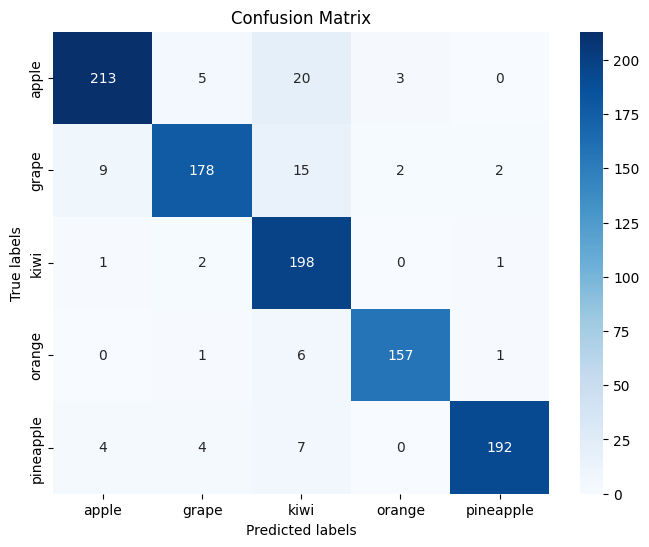

In [7]:
import numpy as np
# Assuming you have a mapping of class indices to class names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
# Get true labels from the test set generator
true_labels = test_generator.classes
# Assuming you have your model and test_generator defined
predicted_probs = model.predict_generator(test_generator)
predicted_labels = np.argmax(predicted_probs, axis=1)

# Create Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix with Class Names
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


loss function

roc curve


/tmp/ipykernel_42/1649539200.py:8: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predicted_probs = model.predict_generator(test_generator)


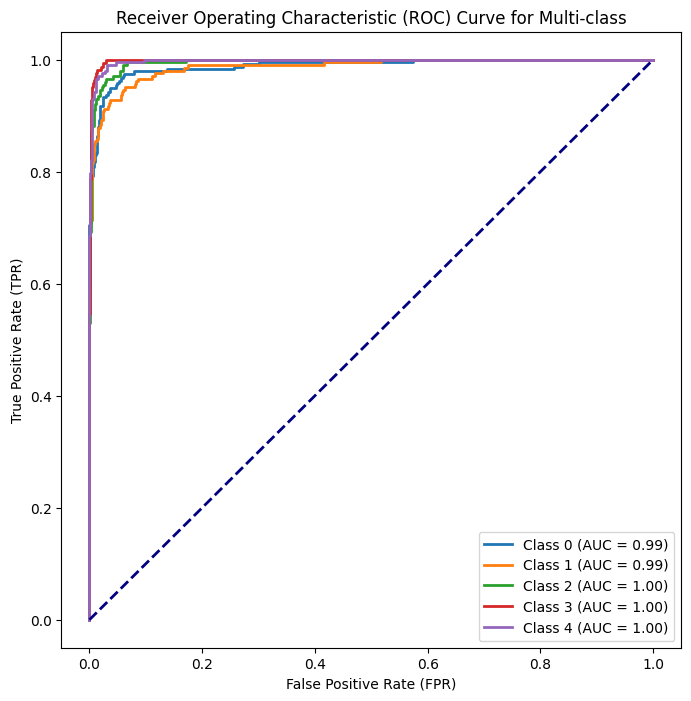

In [8]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Assuming you have your model and test_generator defined
predicted_probs = model.predict_generator(test_generator)
true_labels = test_generator.classes
num_classes = len(np.unique(true_labels))

# Binarize the true labels
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

# Initialize variables for ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc='lower right')
plt.show()


11/11 [==============================] - 2s 188ms/step


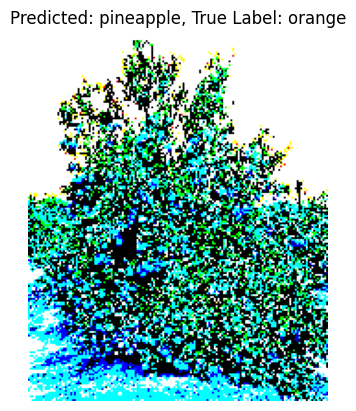

In [9]:
import matplotlib.pyplot as plt

# Assuming you have a mapping of class indices to class names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Load a batch of test images and labels
test_images, test_labels = test_generator.next()

# Generate predictions for the entire test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes

# Find misclassified indices
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Select a random misclassified index from the list of misclassified indices
random_misclassified_index = random.choice(misclassified_indices)

# Find the batch index and the index within the batch for the misclassified image
batch_index = random_misclassified_index // batch_size
index_in_batch = random_misclassified_index % batch_size

# Retrieve the batch containing the misclassified image and labels
misclassified_batch_images, misclassified_batch_labels = test_generator[batch_index]

# Extract the misclassified image and its label from the batch
misclassified_image = misclassified_batch_images[index_in_batch]
misclassified_label_index = predicted_labels[random_misclassified_index]
true_label_index = true_labels[random_misclassified_index]

# Convert numerical labels to class names
misclassified_label = class_names[misclassified_label_index]
true_label = class_names[true_label_index]

# Display the misclassified image
plt.imshow(misclassified_image)
plt.title(f"Predicted: {misclassified_label}, True Label: {true_label}")
plt.axis('off')
plt.show()


In [11]:
model.save('/kaggle/working/cnn_object_detection.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
